# Setup

- The Liesel documentation can be found here: https://docs.liesel-project.org/en/latest/
- Track the release of new versions and report bugs here: https://github.com/liesel-devs/liesel
- Please feel invited to ask questions here: https://github.com/liesel-devs/liesel/discussions

In [1]:
# This cell installs the necessary packages.
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# %%capture
# !apt install libgraphviz-dev # necessary here for successful pygraphviz installation
# %pip install pygraphviz # install pygraphviz (for plotting model graphs nicely)
# %pip install rpy2 # install rpy2 for interfacing R and Python
# %pip install liesel # install liesel
# %pip install plotnine # install plotnine for ggplot2-like plotting in Python


In [2]:
# This cell installs R, mgcv and BayesX for us
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# careful, the installation of BayesX takes a long time!

# the command '%%capture' prevents ouput from being continuously printed
# this is nice here, because the output is very long

# %%capture
# !apt-get install -y r-base
# !Rscript -e "install.packages('mgcv', repos='http://cran.rstudio.com/')"
# !Rscript -e "install.packages('BayesX', repos='http://cran.rstudio.com/')"

In [3]:
%load_ext rpy2.ipython

In [4]:
import numpy as np # for numerical operations
import jax.numpy as jnp # for jit-compilable numerical operations
import tensorflow_probability.substrates.jax.distributions as tfd # for probability distributions


import liesel.model as lsl # Liesel's model-building module
import liesel.goose as gs # Liesel's MCMC module
from liesel.distributions import MultivariateNormalDegenerate as MVND # for the rank-deficient multivariate normal distribution

import plotnine as p9 # for ggplot2-like plotting

In [5]:
# for interfacing R and Python
from rpy2 import robjects

robjects.pandas2ri.activate()

# Data Import

In [6]:
%%R
library(mgcv)

rent <- read.table("https://raw.githubusercontent.com/liesel-devs/florence-2025/refs/heads/main/data/rent.dat", header=TRUE)
rent_test <- read.table("https://raw.githubusercontent.com/liesel-devs/florence-2025/refs/heads/main/data/rent_test.dat", header=TRUE)

rent$location <- as.factor(rent$location)
rent_test$location <- as.factor(rent_test$location)
rent$district <- as.factor(rent$district)
rent_test$district <- factor(rent_test$district, levels = levels(rent$district))

Lade nötiges Paket: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [7]:
# pass the zambia data frame to Python
# we explicitly convert the data frame to a pandas data frame
rent = robjects.globalenv['rent']
rent_test = robjects.globalenv['rent_test']

# Model setup

In [8]:
%%R
# Area effect
s_area <- s(area, bs="ps", m=c(3,2), k=20) |> 
    mgcv::smoothCon(data = rent, absorb.cons = TRUE)

basis_area_r <- s_area[[1]]$X
pen_area_r <- s_area[[1]]$S[[1]]

In [9]:
%%R
# Area effect
s_year <- s(yearc, bs="ps", m=c(3,2), k=20) |> 
    mgcv::smoothCon(data = rent, absorb.cons = TRUE)

basis_year_r <- s_year[[1]]$X
pen_year_r <- s_year[[1]]$S[[1]]

In [10]:
%%R
# Area effect
s_district <- s(district, bs="re") |> 
    mgcv::smoothCon(data = rent, absorb.cons = TRUE)

basis_district_r <- s_district[[1]]$X
pen_district_r <- s_district[[1]]$S[[1]]

In [11]:
# get R objects into python
basis_area_r = robjects.globalenv['basis_area_r']
pen_area_r = robjects.globalenv['pen_area_r']
test_basis_area_r = robjects.globalenv['test_basis_area_r']

basis_year_r = robjects.globalenv['basis_year_r']
pen_year_r = robjects.globalenv['pen_year_r']
test_basis_year_r = robjects.globalenv['test_basis_year_r']

basis_district_r = robjects.globalenv['basis_district_r']
pen_district_r = robjects.globalenv['pen_district_r']
test_basis_district_r = robjects.globalenv['test_basis_district_r']

In [12]:
# set up structured additive term in liesel
basis_area = lsl.Var.new_obs(basis_area_r, name="basis_area")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_area_r)

# set up tau2 prior and variable
# tau2_area_loc_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_area_loc = lsl.Var.new_param(10.0, tau2_area_loc_prior, name="tau2_area_loc")
# var_param_area_loc = tau2_area_loc

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_area_loc_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_area_loc = lsl.Var.new_param(10.0, tau_area_loc_prior, name="tau_area_loc")
tau2_area_loc = lsl.Var.new_calc(jnp.square, tau_area_loc, name="tau2_area_loc")
var_param_area_loc = tau_area_loc

# set up coefficient prior
coef_area_loc_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_area_loc,
    pen=pen_area_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_area_loc = lsl.Var.new_param(
    value=jnp.zeros(basis_area_r.shape[1]),
    distribution=coef_area_loc_prior,
    name="coef_area_loc"
)

# set up effect variable
s_area_loc = lsl.Var.new_calc(jnp.dot, basis_area, coef_area_loc, name="s_area_loc")

In [13]:
# set up structured additive term in liesel
basis_year = lsl.Var.new_obs(basis_year_r, name="basis_year")


mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_year_r)

# set up tau2 prior and variable
# tau2_year_loc_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_year_loc = lsl.Var.new_param(10.0, tau2_year_loc_prior, name="tau2_year_loc")
# var_param_year_loc = tau2_year_loc

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_year_loc_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_year_loc = lsl.Var.new_param(10.0, tau_year_loc_prior, name="tau_year_loc")
tau2_year_loc = lsl.Var.new_calc(jnp.square, tau_year_loc, name="tau2_year_loc")
var_param_year_loc = tau_year_loc

# set up coefficient prior
coef_year_loc_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_year_loc,
    pen=pen_year_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_year_loc = lsl.Var.new_param(
    value=jnp.zeros(basis_year_r.shape[1]),
    distribution=coef_year_loc_prior,
    name="coef_year_loc"
)

# set up effect variable
s_year_loc = lsl.Var.new_calc(jnp.dot, basis_year, coef_year_loc, name="s_year_loc")

In [14]:
# set up structured additive term in liesel
basis_district = lsl.Var.new_obs(basis_district_r, name="basis_district")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_district_r)

# set up tau2 prior and variable
# tau2_district_loc_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_district_loc = lsl.Var.new_param(10.0, tau2_district_loc_prior, name="tau2_district_loc")
# var_param_district_loc = tau2_district_loc

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_district_loc_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_district_loc = lsl.Var.new_param(10.0, tau_district_loc_prior, name="tau_district_loc")
tau2_district_loc = lsl.Var.new_calc(jnp.square, tau_district_loc, name="tau2_district_loc")
var_param_district_loc = tau_district_loc

# set up coefficient prior
coef_district_loc_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_district_loc,
    pen=pen_district_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_district_loc = lsl.Var.new_param(
    value=jnp.zeros(basis_district_r.shape[1]),
    distribution=coef_district_loc_prior,
    name="coef_district_loc"
)

# set up effect variable
s_district_loc = lsl.Var.new_calc(jnp.dot, basis_district, coef_district_loc, name="s_district_loc")

In [15]:
%%R
basis_location <- model.matrix(~location, data = rent)[,-1]

In [16]:
basis_location_r = robjects.globalenv['basis_location']

In [17]:
basis_location = lsl.Var.new_obs(basis_location_r, name="basis_location")
coef_location_loc = lsl.Var.new_param(
    jnp.zeros(basis_location.value.shape[1]),
    name="coef_location_loc"
)
s_location_loc = lsl.Var.new_calc(jnp.dot, basis_location, coef_location_loc, name="s_location_loc")

In [18]:
intercept_loc = lsl.Var.new_param(
    rent["rentsqm"].mean(), name="intercept_loc"  # crude starting value
)

loc = lsl.Var.new_calc(
    lambda *args: sum(args),
    intercept_loc,
    s_area_loc,
    s_district_loc,
    s_year_loc,
    s_location_loc,
    name="loc",
)


variance = lsl.Var.new_param(
    rent["rentsqm"].var(),  # crude starting value
    lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01),
    name="variance",
)

scale = lsl.Var.new_calc(jnp.sqrt, variance, name="scale")

rentsqm_dist = lsl.Dist(tfd.Normal, loc=loc, scale=scale)
rentsqm = lsl.Var.new_obs(
    rent["rentsqm"].values, distribution=rentsqm_dist, name="rentsqm"
)

In [19]:
model1 = lsl.Model([rentsqm])
interface = gs.LieselInterface(model1)

liesel.model.model - INFO - Converted dtype of Value(name="rentsqm_value").value
liesel.model.model - INFO - Converted dtype of Value(name="variance_value").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_location_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_year_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_district_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_area_value").value
liesel.model.model - INFO - Converted dtype of Value(name="intercept_loc_value").value


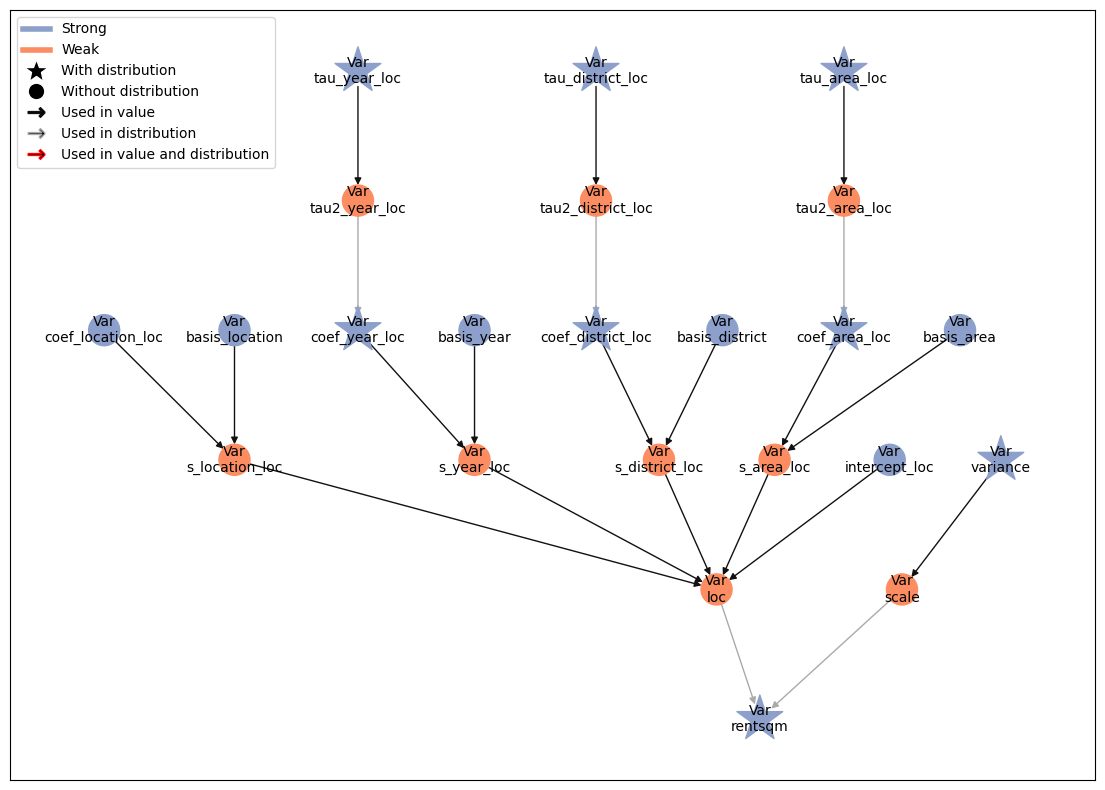

In [20]:
lsl.plot_vars(model1)

# Parameter estimation

## Pre-optimization

In [21]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model1,
    params=[intercept_loc.name, coef_area_loc.name, coef_district_loc.name, coef_year_loc.name, coef_location_loc.name, variance.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 5344.745, Validation loss: 5344.745:  26%|██▌       | 2610/10000 [00:23<01:05, 113.24it/s]

## MCMC Sampling

In [24]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept_loc.name]))

eb.add_kernel(gs.IWLSKernel([coef_area_loc.name]))
eb.add_kernel(gs.IWLSKernel([coef_district_loc.name]))
eb.add_kernel(gs.IWLSKernel([coef_year_loc.name]))
eb.add_kernel(gs.IWLSKernel([coef_location_loc.name]))

eb.add_kernel(gs.NUTSKernel([var_param_area_loc.name]))
eb.add_kernel(gs.NUTSKernel([var_param_district_loc.name]))
eb.add_kernel(gs.NUTSKernel([var_param_year_loc.name]))

eb.add_kernel(gs.NUTSKernel([variance.name]))

eb.positions_included = [s_area_loc.name, s_district_loc.name, s_year_loc.name, s_location_loc.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

In [25]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [26]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:13<00:00,  4.47s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 4, 1, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 11, 8, 8, 5 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_06: 2, 5, 5, 3 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_07: 10, 7, 12, 6 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_08: 0, 2, 1, 1 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 615.45chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per ch

In [27]:
results1 = engine.get_results()
samples1 = results1.get_posterior_samples()
summary1 = gs.Summary(results1, deselected=eb.positions_included)

# Evaluate log density at test data

## Basis matrices

In [ ]:
%%R
test_basis_area_r <- s_area[[1]] |> mgcv::PredictMat(rent_test)
test_basis_year_r <- s_year[[1]] |> mgcv::PredictMat(rent_test)
test_basis_district_r <- s_district[[1]] |> mgcv::PredictMat(rent_test)
test_basis_location <- model.matrix(~location, data = rent_test)[,-1]

In [ ]:
# get R objects into python
test_basis_area_r = robjects.globalenv['test_basis_area_r']
test_basis_year_r = robjects.globalenv['test_basis_year_r']
test_basis_district_r = robjects.globalenv['test_basis_district_r']
test_basis_location_r = robjects.globalenv['test_basis_location']

## Update model variables with test data

In [31]:
nodes, vars_ = model1.copy_nodes_and_vars()

vars_["rentsqm"].value = rent_test["rentsqm"].values

vars_["basis_area"].value = test_basis_area_r
vars_["basis_district"].value = test_basis_district_r
vars_["basis_year"].value = test_basis_year_r
vars_["basis_location"].value = test_basis_location_r

vars_["coef_area_loc"].value = summary1.quantities["mean"]["coef_area_loc"]
vars_["coef_district_loc"].value = summary1.quantities["mean"]["coef_district_loc"]
vars_["coef_year_loc"].value = summary1.quantities["mean"]["coef_year_loc"]
vars_["coef_location_loc"].value = summary1.quantities["mean"]["coef_location_loc"]

vars_["intercept_loc"].value = summary1.quantities["mean"]["intercept_loc"]

vars_["variance"].value = summary1.quantities["mean"]["variance"]

model_test = lsl.Model([vars_["rentsqm"]])

liesel.model.model - INFO - Converted dtype of Value(name="rentsqm_value").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_location_value").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_year_value").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_district_value").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_area_value").value


## Evaluate log likelihood

In [32]:
model_test.log_lik

Array(-2088.5383, dtype=float32)

In [33]:
model_test.vars["rentsqm"].log_prob.sum()

Array(-2088.5383, dtype=float32)